In [2]:
# install transformer moels
%pip install accelerate transformers bertopic top2vec[sentence_transformers]
%pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/


### 1. Import the required libraries

In [3]:
# import libraries
import warnings
import os
from torch import cuda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import timeit
import platform
from pathlib import Path
from datetime import datetime

# Tokenization tools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
import re

# Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Coherence
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import tokenize

# Word Clouds
from wordcloud import WordCloud

### 2. Class to calculate Coherence Score

In [4]:
# class to calculate coherence score
class Metrics():

  def bert_coherence(self, sentences, topics):

    # Preprocess Documents
    documents = pd.DataFrame({
        "Document": sentences,
        "ID": range(len(sentences)),
        "Topic": topics}
    )
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = BERTopic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = BERTopic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = []
    for topic in set(topics):
        try:
            topic_data = BERTopic_model.get_topic(topic)
            if topic_data:  # Ensure the topic is valid
                topic_words.append([word for word, _ in topic_data])
        except Exception as e:
            print(f"Error processing topic {topic}: {e}")

    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    return coherence

    def t2v_coherence(self, sentences, topics):
      tokenized = [list(tokenize(doc)) for doc in sentences]
      id2word = corpora.Dictionary(tokenized)
      corpus = [id2word.doc2bow(text) for text in tokenized]

      # make sure you grab the topic words from the topic model and convert them to a list
      coherence_model = CoherenceModel(
          topics = topics,
          texts=tokenized,
          corpus=corpus,
          dictionary=id2word,
          coherence='c_v',
          topn=10
      )
      coherence = coherence_model.get_coherence()
      return coherence


### 3. Read the Dataset

In [5]:
# read the dataset, read a txt file as csv
df = pd.read_csv('cleaned_submissions.csv')
df.head()

<ipython-input-5-e1cdefb35260>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_submissions.csv')


,Unnamed: 0,id,created,author,author_flair_text,score,num_comments,link,cleaned_title,cleaned_bodytext,title+bodytext,word_count,in_english,vader_score,vader_neg,vader_neu,vader_pos,vader_compound,year,month
0,0,fs5kt,2011-02-24 17:30,u/someprimetime,NaN,8,0,https://www.reddit.com/r/LifeProTips/comments/...,tips for being successful in the workplace as ...,NaN,tips for being successful in the workplace as ...,14,True,"{'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compou...",0.0,0.670,0.330,0.7096,2011,2
1,1,fs4yb,2011-02-24 16:59,u/someprimetime,NaN,3,0,https://www.reddit.com/r/LifeProTips/comments/...,if you are using google chrome start typing th...,NaN,if you are using google chrome start typing th...,43,True,"{'neg': 0.0, 'neu': 0.969, 'pos': 0.031, 'comp...",0.0,0.969,0.031,0.0772,2011,2
2,2,fs4xb,2011-02-24 16:57,u/someprimetime,NaN,12,7,https://www.reddit.com/r/LifeProTips/comments/...,when applying eyedrops dont drop them inside t...,NaN,when applying eyedrops dont drop them inside t...,17,True,"{'neg': 0.0, 'neu': 0.898, 'pos': 0.102, 'comp...",0.0,0.898,0.102,0.2057,2011,2
3,6,fros1,2011-02-24 02:50,u/someprimetime,NaN,0,6,https://www.reddit.com/r/LifeProTips/comments/...,beer before liquor never been sicker liquor b...,NaN,beer before liquor never been sicker liquor b...,13,True,"{'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'comp...",0.0,0.822,0.178,0.3818,2011,2
4,7,fromj,2011-02-24 02:39,u/someprimetime,NaN,69,4,https://www.reddit.com/r/LifeProTips/comments/...,when your significant other isnt around take m...,NaN,when your significant other isnt around take m...,16,True,"{'neg': 0.0, 'neu': 0.893, 'pos': 0.107, 'comp...",0.0,0.893,0.107,0.2023,2011,2


In [6]:
# shape of the data
df.shape

(561943, 20)

In [7]:
# data types of columns
df.dtypes

,0
Unnamed: 0,int64
id,object
created,object
author,object
author_flair_text,object
score,int64
num_comments,int64
link,object
cleaned_title,object
cleaned_bodytext,float64


In [8]:
df['year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023])

### 4. Exploratory Data Analysis

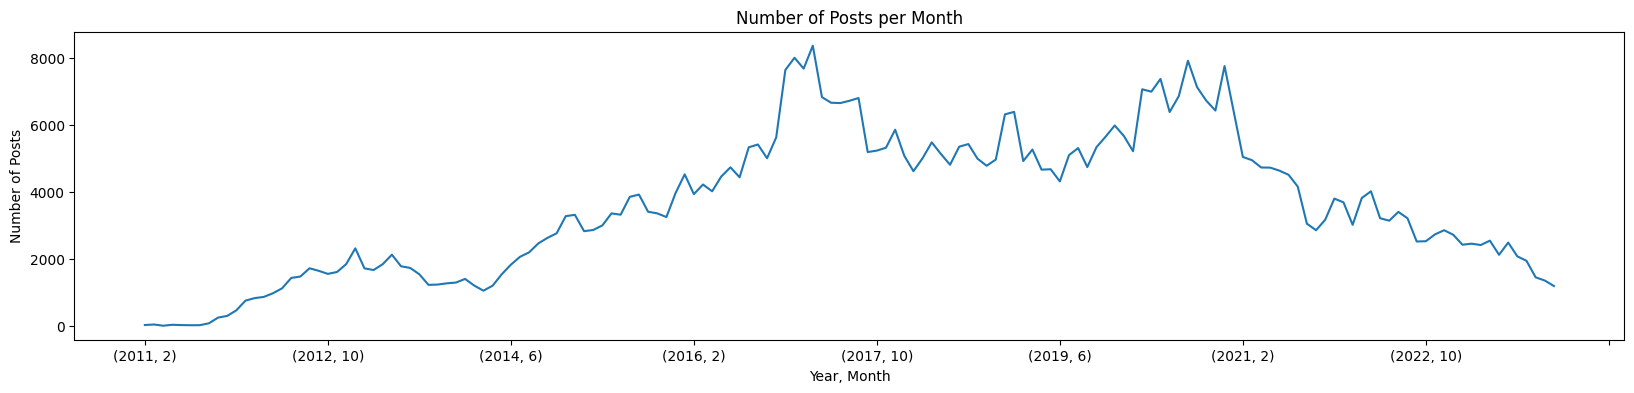

In [9]:
# plot the number of fact checks per month
plt.figure(figsize=(20, 4))
df.groupby(['year', 'month']).size().plot()
plt.title('Number of Posts per Month')
plt.xlabel('Year, Month')
plt.ylabel('Number of Posts')
plt.show()

<ipython-input-10-cae6c4bae7ba>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='year', data=df, palette='coolwarm')


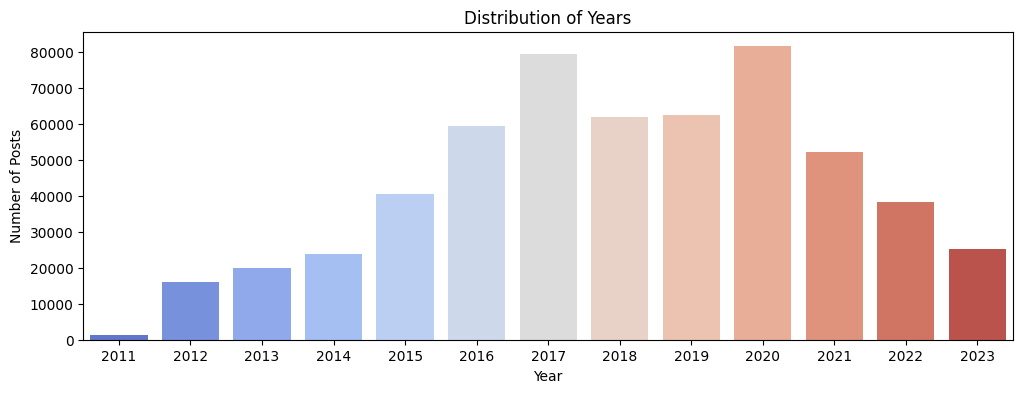

In [10]:
plt.figure(figsize=(12, 4))
sns.countplot(x='year', data=df, palette='coolwarm')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.show()

In [11]:
# convert the data type to object for title+bodytext
df['title+bodytext'] = df['title+bodytext'].astype(str)

In [12]:
# distribution of LPT vs LPTR
# create a variable type, 1:LPT, 2:LPTR, and 3:else if the title+bodytext begins with LPT, LPTR
def determine_type(row):
    text = row['title+bodytext'].strip()
    if text.startswith("lpt request"):
        return 1
    elif text.startswith("lpt"): # add lpt request
        return 2
    else:
        return 3

df['type'] = df.apply(determine_type, axis=1)

<ipython-input-13-d4e2b61b2eec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='coolwarm')


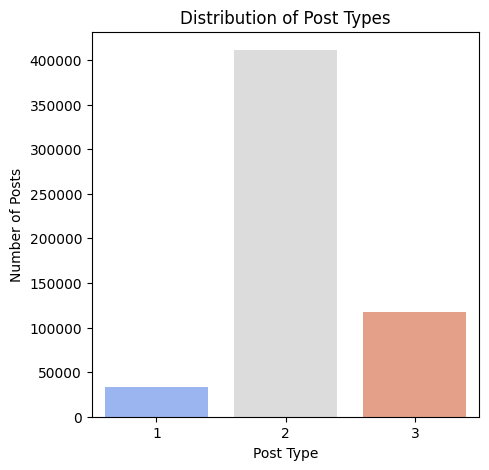

In [13]:
# idstribution plot for type of the posts
plt.figure(figsize=(5, 5))
sns.countplot(x='type', data=df, palette='coolwarm')
plt.title('Distribution of Post Types')
plt.xlabel('Post Type')
plt.ylabel('Number of Posts')
plt.show()

## **BERTopic Implementation**

In [14]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# get the data for years from 2019 to 2022
df1 = df[(df['year'] >= 2019) & (df['year'] <= 2022)]

In [16]:
# shape of teh data
df1.shape

(234323, 21)

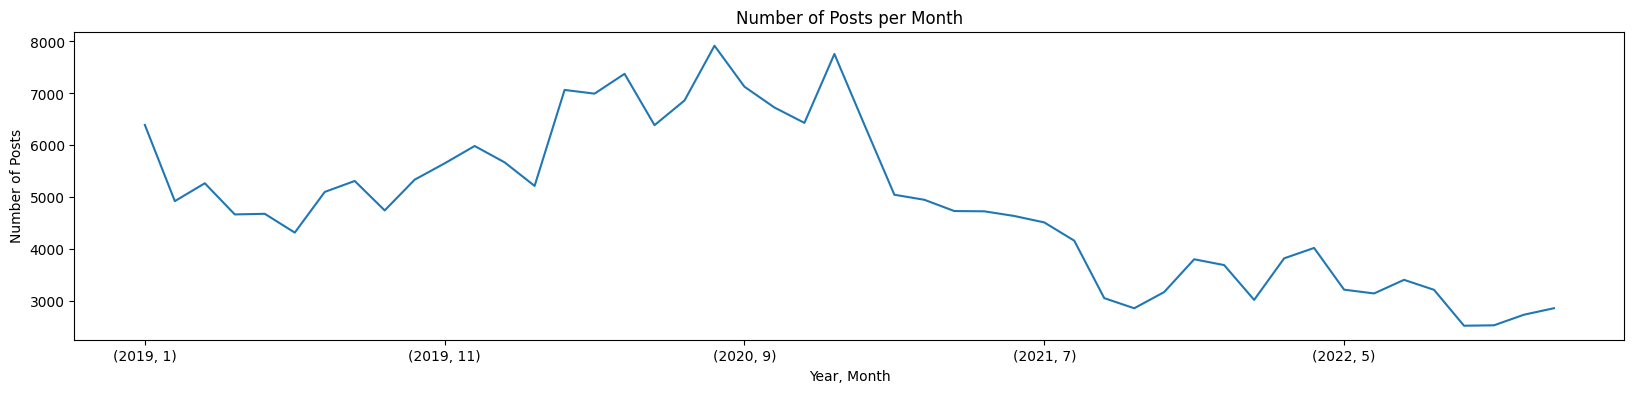

In [17]:
# plot the number of fact checks per month
plt.figure(figsize=(20, 4))
df1.groupby(['year', 'month']).size().plot()
plt.title('Number of Posts per Month')
plt.xlabel('Year, Month')
plt.ylabel('Number of Posts')
plt.show()

### 5. Preprocessing of the Posts

In [18]:
# preprocess the text data
# remove stopwords
stop_words = set(stopwords.words('english'))

# get the reddit posts
posts = df1['title+bodytext']

# drop NaN values
posts = posts.dropna()


# Custom stopwords specific to our data
custom_stopwords = {'lpt', 'request', 'lpts', 'lptr', 'lptgood', 'lptnext',
                    'lptdo', 'lptrequest', 'lp', 'lptyou', "pro", "tip",
                    "advice", "tips", "helpful", "idea", "advices", "protip",
                    "protips"}
all_stopwords = stop_words.union(custom_stopwords)

# Sample data
posts = posts.apply(lambda x: " ".join([word for word in x.lower().split() if word not in all_stopwords]))

In [19]:
## lemmitization and stemming
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Lemmatization
lemmatizer = WordNetLemmatizer()
posts = posts.apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
print(posts.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


302321    tired tangling cable string clip end string to...
302322    bring wine party make sure bring corkscrew hou...
302323         dont forget put 1119 paperwork youre welcome
302324    new year back want delete text message voicema...
302325    drunk party need get home help clean wait sobe...
Name: title+bodytext, dtype: object


In [20]:
posts = posts.tolist()

In [21]:
# length of posts
len(posts)

234323

In [22]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from torch import bfloat16
import transformers
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

In [ ]:
# import the embedding_model
embeddings = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# train the BERTopic model
min_topic_size = 300

BERTopic_model = BERTopic(
    embedding_model=embeddings,
    min_topic_size=min_topic_size,
    verbose=True
)
topics, probs = BERTopic_model.fit_transform(posts)

2025-03-01 21:36:28,869 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/7323 [00:00<?, ?it/s]

2025-03-01 21:38:27,692 - BERTopic - Embedding - Completed ✓
2025-03-01 21:38:27,695 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-01 21:44:58,807 - BERTopic - Dimensionality - Completed ✓
2025-03-01 21:44:58,817 - BERTopic - Cluster - Start clustering the reduced embeddings


In [24]:
BERTopic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,310,-1_tattoo_yawn_pistachio_shell,"[tattoo, yawn, pistachio, shell, open, someone...",[tattoo permanent remember get urge get tattoo...
1,0,227352,0_dont_get_youre_make,"[dont, get, youre, make, use, time, want, some...",[youre going generous holiday season get someo...
2,1,4442,1_dog_pet_cat_animal,"[dog, pet, cat, animal, get, dont, vet, food, ...","[people go depression please get pet dog, litt..."
3,2,2219,2_battery_phone_charger_charge,"[battery, phone, charger, charge, charging, us...",[phone cant hold charge anymore doesnt removab...


In [25]:
#viz_embeddings = embeddings.encode(posts, show_progress_bar=False)
#BERTopic_model.visualize_documents(posts, embeddings=viz_embeddings)

In [26]:
BERTopic_model.visualize_topics()

/usr/local/lib/python3.11/dist-packages/umap/spectral.py:519: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [27]:
BERTopic_model.visualize_heatmap()

In [ ]:
BERTopic_model.visualize_barchart(n_words=10, top_n_topics=20)

In [ ]:
BERTopic_model.save("my_model.pkl", serialization="pickle")